In [2]:
import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
from Tavtigian.tavtigianutils import get_tavtigian_c, get_tavtigian_thresholds
from configmodule import ConfigModule
from LocalCalibration.gaussiansmoothing import *
from LocalCalibration.LocalCalibration import LocalCalibration
from Tavtigian.Tavtigian import LocalCalibrateThresholdComputation
from infer import *
from utils import *

## Load scores for labelled and unlabelled samples

In [3]:
x,y = load_labelled_data("../pndata.txt")
g = load_unlabelled_data("../pudata.txt")

## Specify Parameters

In [17]:
alpha = 0.041
g = np.sort(g)
xg = np.concatenate((x,g))
reverse = False
windowclinvarpoints = 100
windowgnomadfraction = 0.03
gaussian_smoothing = False
data_smoothing = True
emulate_tavtigian = False
emulate_pejaver = True
B = 1000
discountonesided = 0.05

## Perform Calibration

In [5]:
calib = LocalCalibration(alpha, reverse, windowclinvarpoints, windowgnomadfraction, gaussian_smoothing, data_smoothing)
thresholds, posteriors_p = calib.fit(x,y,g,alpha)
posteriors_b = 1 - np.flip(posteriors_p)

## Compute c and Score

In [6]:
c = None
if (emulate_tavtigian):
    alpha = 0.1
    c = 350
elif (emulate_pejaver):
    alpha = 0.0441
    c = 1124
else:
    c = get_tavtigian_c(alpha)

Post_p, Post_b = get_tavtigian_thresholds(c, alpha)

## Compute 95% scoure thresholds using BootStrapping

In [13]:
calib = LocalCalibrateThresholdComputation(alpha, c, reverse, windowclinvarpoints, windowgnomadfraction, gaussian_smoothing, data_smoothing)
_, posteriors_p_bootstrap = calib.get_both_bootstrapped_posteriors_parallel(x,y, g, B, alpha, thresholds)

In [29]:
all_pathogenic = np.row_stack((posteriors_p, posteriors_p_bootstrap))
all_benign = 1 - np.flip(all_pathogenic, axis = 1)

benign95= [np.percentile(e,5) for e in all_benign.T]
pathogenic95 = [np.percentile(e,5) for e in all_pathogenic.T]

## Plot score-posterior graph

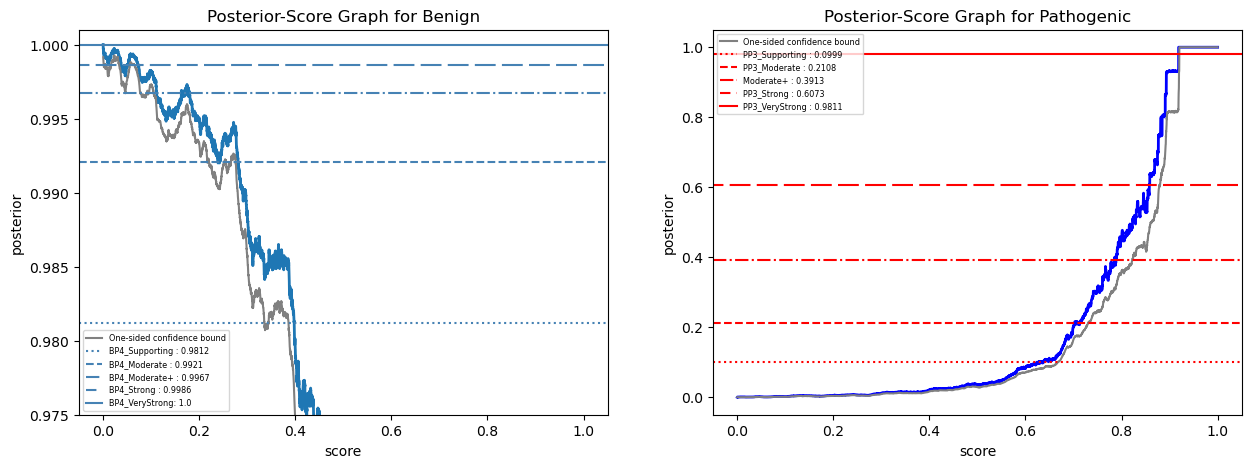

In [33]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax0 = ax[0]
ax1 = ax[1]
ax0.plot(np.flip(thresholds),posteriors_b , linewidth=2.0)
ax0.plot(np.flip(thresholds),benign95, color='gray', label = "One-sided confidence bound")
ax0.set_xlabel("score")
ax0.set_ylabel("posterior")
ax0.set_title("Posterior-Score Graph for Benign")
ax0.axhline(Post_b[4], linestyle='dotted', color='steelblue', label = "BP4_Supporting : " + str(round(Post_b[4],4)) )
ax0.axhline(Post_b[3], linestyle='dashed', color='steelblue', label = "BP4_Moderate : " + str(round(Post_b[3],4)) )
ax0.axhline(Post_b[2], linestyle='dashdot', color='steelblue', label = "BP4_Moderate+ : " + str(round(Post_b[2],4)) )
ax0.axhline(Post_b[1], linestyle=(5, (10, 3)), color='steelblue', label = "BP4_Strong : " + str(round(Post_b[1],4)) )
ax0.axhline(Post_b[0], linestyle='solid', color='steelblue', label = "BP4_VeryStrong: " + str(round(Post_b[0],4)) ) 
ax0.set_ylim([0.975, 1.001])
ax0.legend(loc="lower left", fontsize="xx-small")
#plt.savefig(os.path.join(outdir,"benign.png"))
#ax.clear()

ax1.plot(thresholds,posteriors_p , linewidth=2.0, color='b')
ax1.plot(thresholds,pathogenic95, color='gray', label = "One-sided confidence bound")
ax1.set_xlabel("score")
ax1.set_ylabel("posterior")
ax1.set_title("Posterior-Score Graph for Pathogenic")
ax1.axhline(Post_p[4], linestyle='dotted', color='r' ,label = "PP3_Supporting : " + str(round(Post_p[4],4)))
ax1.axhline(Post_p[3], linestyle='dashed', color='r', label = "PP3_Moderate : " + str(round(Post_p[3],4)))
ax1.axhline(Post_p[2], linestyle='dashdot', color='r', label = "Moderate+ : " + str(round(Post_p[2],4)))
ax1.axhline(Post_p[1], linestyle=(5, (10, 3)), color='r', label = "PP3_Strong : " + str(round(Post_p[1],4)))
ax1.axhline(Post_p[0], linestyle='solid', color='r', label = "PP3_VeryStrong : " + str(round(Post_p[0],4)))
ax1.legend(loc="upper left", fontsize="xx-small")
#plt.savefig(os.path.join(outdir, "pathogenic.png"))

In [34]:
pthresh = LocalCalibrateThresholdComputation.get_all_thresholds(all_pathogenic, thresholds, Post_p)
bthresh = LocalCalibrateThresholdComputation.get_all_thresholds(all_benign, np.flip(thresholds), Post_b) 

DiscountedThresholdP = LocalCalibrateThresholdComputation.get_discounted_thresholds(pthresh, Post_p, B, discountonesided, 'pathogenic')
DiscountedThresholdB = LocalCalibrateThresholdComputation.get_discounted_thresholds(bthresh, Post_b, B, discountonesided, 'benign')

In [36]:
DiscountedThresholdP

array([0.9203, 0.8823, 0.8285, 0.7325, 0.6685])